# RowDecoder 4x

After exploring the RowDecoder 1x and 2x, we can now explore the RowDecoder 4x. Here again, only the fanIn-2 cells are considered

In [1]:
from circuit import *
from optimum_sizing import *
from metal import *

# Library needed to print with the "Engineering Notation" the results
from quantiphy import Quantity

#### Some constant definitions

In [2]:
TAU_1 = 6.18e-12                                    # Intrinsic delay of the inverter (s)
TAU_2 = 3.717e-12                                   # Effort delay of the inverter (s)
TAU_RATIO = TAU_1 / TAU_2                           # Tau ratio

BETA_OPT = 2.5                                      # Beta factor
BETA_FIRST = 2                                      # Beta factor first buffer
C_INT_TRANS = 0.5e-15 / (BETA_OPT + 1)              # Intrinsic capacitance of the transistor (F)
C_GATE_INV = C_INT_TRANS * (BETA_OPT + 1)           # Gate capacitance of the inverter (F)
S_WIRE = 0.1                                        # Minimum distance between wires (um)
W_WIRE_STANDARD = 0.1                               # Standard width of the wire (um)

L_BITCELL = 1                                       # length of the cell (um)              
W_BITCELL = 0.5                                     # height of the cell (um)

WORD_SIZE = 32
ADDRESS_NB = 256

WL_LENGTH = WORD_SIZE * L_BITCELL
PRE2POST_DECODER_LENGTH = ADDRESS_NB * W_BITCELL

BITCELL_CAP = 2 * WORD_SIZE * C_INT_TRANS           # Input cap of the whole

#### Some metal definitions

In [3]:
# Dummy metal (0 resistance, 0 capacitance)
DUMMY_METAL = Metal("dummy_metal", 0, 0.0001, 0, S_WIRE, 1)
print(DUMMY_METAL)

# Metal from pre-decoder to post-decoder without buffers
pre_post_metal = Metal("pre_post_metal", 2, W_WIRE_STANDARD, PRE2POST_DECODER_LENGTH, S_WIRE, False)
print(pre_post_metal)

# Metal from post-decoder to WL
post_WL_metal = Metal("post_WL_metal", 3, W_WIRE_STANDARD, WL_LENGTH, W_BITCELL, True)
print(post_WL_metal)

dummy_metal
	L = 0
	R_tot = 0 Ohm
	W = 0.0001
	C_wire = 0 F
	C_tot = 0 F
	Delay = 0 s

pre_post_metal
	L = 128.0
	R_tot = 134.4 Ohm
	W = 0.1
	C_wire = 1.7664 fF
	C_tot = 38.118 fF
	Delay = 1.7675 ps

post_WL_metal
	L = 32
	R_tot = 33.6 Ohm
	W = 0.1
	C_wire = 364.8 aF
	C_tot = 1.7472 fF
	Delay = 20.254 fs



## Architecture
The architecture we are exploring is the following one\
\
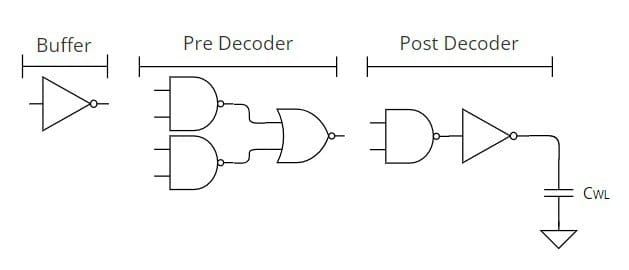
#### Define the FanIn/FanOut of the different stages

In [4]:
group = 4                                # Number of bits per group 

# Define some useful variables
DRIVER_FO  = np.power(2,(group-1))       # Fan-out of the input driver
PREDEC_FI  = group                       # Fan-in of the predecoder gate
PREDEC_FO  = np.power(2, (8 - group))    # Pre-decored fan-out
POSTDEC_FI = 8//group                    # Post-decoder fan-in

PREDEC_FI_ARCH1 = 2

In [5]:
# print the Fanout/Fanin of the different stages
print("DRIVER_FO        =   " + str(DRIVER_FO))
print("PREDEC_FI        =   " + str(PREDEC_FI))
print("PREDEC_FO        =   " + str(PREDEC_FO))
print("POSTDEC_FI       =   " + str(POSTDEC_FI))
print("PREDEC_FI_ARCH1  =   " + str(PREDEC_FI_ARCH1))

DRIVER_FO        =   8
PREDEC_FI        =   4
PREDEC_FO        =   16
POSTDEC_FI       =   2
PREDEC_FI_ARCH1  =   2


#### Define all the gates of this architecture

In [6]:
input_buffer = Inverter("input_buffer", BETA_FIRST, BETA_OPT, 1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

# Predecoder
nand_pre_list = []
for i in range(DRIVER_FO):
    nand_predec = Nand("nand_predec_" + str(i), BETA_OPT, BETA_OPT, 1, PREDEC_FI_ARCH1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
    nand_pre_list.append(nand_predec)

nand_branch_pre = Branch("nand_branch_predec", nand_pre_list)
nor_pre = Nor("nor_predec", BETA_OPT, BETA_OPT, 1, 2, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

# Postdecoder
nand_post_list = list()
for i in range(PREDEC_FO):
    nand_post =  Nand("nand_postdec_" + str(i), BETA_OPT, BETA_OPT, 1, POSTDEC_FI, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
    nand_post_list.append(nand_post)

nand_branch_post = Branch("nand_branch_postdec", nand_post_list)
inv_post = Inverter("inv_postdec", BETA_OPT, BETA_OPT, 1, post_WL_metal, C_INT_TRANS, TAU_RATIO)

#### Optimal number of buffers

In [7]:
# Complete circuit without wire
rowdec_4x_gates = [input_buffer, nand_branch_pre, nor_pre, nand_branch_post, inv_post]
rowdec_4x = Circuit("rowdec_4x", rowdec_4x_gates, TAU_2, TAU_RATIO, (post_WL_metal.Ctot + BITCELL_CAP) / C_GATE_INV)
rowdec_4x.info()

Circuit name: rowdec_4x
╒════════════╤════════════════╤══════════════════════╤══════════════╤═══════════════════════╤═══════════════╕
│            │ input_buffer   │ nand_branch_predec   │ nor_predec   │ nand_branch_postdec   │ inv_postdec   │
╞════════════╪════════════════╪══════════════════════╪══════════════╪═══════════════════════╪═══════════════╡
│ p          │ 1.000          │ 2.000                │ 2.000        │ 2.000                 │ 1.000         │
├────────────┼────────────────┼──────────────────────┼──────────────┼───────────────────────┼───────────────┤
│ g          │ 1.000          │ 1.286                │ 1.714        │ 1.286                 │ 1.000         │
├────────────┼────────────────┼──────────────────────┼──────────────┼───────────────────────┼───────────────┤
│ h          │ 1.286          │ 1.333                │ 0.750        │ 0.778                 │ 25.275        │
├────────────┼────────────────┼──────────────────────┼──────────────┼───────────────────────┼───

In [8]:
optimal_nb_buffer(input_buffer.C_load + nand_branch_pre.C_off, input_buffer.C_in_gate, TAU_RATIO)

Optimal stages number (rho = 3.59) = 1.8230900365269855
the delay is expressed in multiples of TAU_2 and it's only related to the buffers
	 -> delay (exact) = 9.578064075634861
	 -> delay (N = 2) = 9.739532114211341

Optimal stages number (rho = 4) = 1.6812850396923542
	 -> delay (exact) = 9.520497044779304
	 -> delay (N = 2) = 9.739532114211341

Upper even N = 2
	 -> delay = 9.739532114211341

Lower even N = 0
	0 stages does not make sense


The optimal number of stages is 2

#### Generate the circuit

In [9]:
# Adding buffer
buffer1 = Inverter("buffer1", BETA_OPT, BETA_OPT, 1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
buffer2 = Inverter("buffer2", BETA_OPT, BETA_OPT, 1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

rowdec_4x_gates_buffer = [input_buffer, buffer1, buffer2, nand_branch_pre, nor_pre, nand_branch_post, inv_post]
rowdec_4x_buffer = Circuit("rowdec_4x", rowdec_4x_gates_buffer, TAU_2, TAU_RATIO, (post_WL_metal.Ctot + BITCELL_CAP) / C_GATE_INV)
rowdec_4x_buffer.info()

Circuit name: rowdec_4x
╒════════════╤════════════════╤═══════════╤═══════════╤══════════════════════╤══════════════╤═══════════════════════╤═══════════════╕
│            │ input_buffer   │ buffer1   │ buffer2   │ nand_branch_predec   │ nor_predec   │ nand_branch_postdec   │ inv_postdec   │
╞════════════╪════════════════╪═══════════╪═══════════╪══════════════════════╪══════════════╪═══════════════════════╪═══════════════╡
│ p          │ 1.000          │ 1.000     │ 1.000     │ 2.000                │ 2.000        │ 2.000                 │ 1.000         │
├────────────┼────────────────┼───────────┼───────────┼──────────────────────┼──────────────┼───────────────────────┼───────────────┤
│ g          │ 1.000          │ 1.000     │ 1.000     │ 1.286                │ 1.714        │ 1.286                 │ 1.000         │
├────────────┼────────────────┼───────────┼───────────┼──────────────────────┼──────────────┼───────────────────────┼───────────────┤
│ h          │ 1.000          │ 1.000 

#### Optimize the size of the circuit

In [10]:
rowdec_4x_opt = optimize_circuit_size(rowdec_4x_buffer)
rowdec_4x_opt.info()

Circuit name: rowdec_4x_optimized
╒════════════╤════════════════════╤═══════════════╤═══════════════╤══════════════════════════╤══════════════════╤═══════════════════════════╤═══════════════════╕
│            │ input_buffer_opt   │ buffer1_opt   │ buffer2_opt   │ nand_branch_predec_opt   │ nor_predec_opt   │ nand_branch_postdec_opt   │ inv_postdec_opt   │
╞════════════╪════════════════════╪═══════════════╪═══════════════╪══════════════════════════╪══════════════════╪═══════════════════════════╪═══════════════════╡
│ p          │ 1.000              │ 1.000         │ 1.000         │ 2.000                    │ 2.000            │ 2.000                     │ 1.000             │
├────────────┼────────────────────┼───────────────┼───────────────┼──────────────────────────┼──────────────────┼───────────────────────────┼───────────────────┤
│ g          │ 1.000              │ 1.000         │ 1.000         │ 1.286                    │ 1.714            │ 1.286                     │ 1.000         

#### Add the wire by increasing the fanout of the nor of the predecoder to achieve a Coff = Coff_branch + Cwire

In [11]:
# Real size nand
nand = Nand("nand", BETA_OPT, BETA_OPT, 2, 2, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

# If we increase the fanout of the sized nand to achieve a Coff that is Coff_branch + Cwire
additional_FO = round(pre_post_metal.Ctot / nand.C_in_gate)
print(f"Additional Nand FanOut = {additional_FO}")

Additional Nand FanOut = 30


In [12]:
GAMMA_NAND_POST = 2
GAMMA_INV_POST = 7

In [13]:
nand_branch_with_wire = list()
for i in range(PREDEC_FO + additional_FO):
    nand_4x_postDec =  Nand("nand_4x_post_" + str(i), BETA_OPT, BETA_OPT, GAMMA_NAND_POST, POSTDEC_FI, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
    nand_branch_with_wire.append(nand_4x_postDec)

nand_branch_wire = Branch("nand_post", nand_branch_with_wire)

inv_final = Inverter("inv_final", BETA_OPT, BETA_OPT, GAMMA_INV_POST, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

In [14]:
predec_gates = [input_buffer, buffer1, buffer2, nand_branch_pre, nor_pre]
predec = Circuit("RowDecoder 4x - Predecoder", predec_gates, TAU_2, TAU_RATIO, (nand_branch_wire.C_in_gate + nand_branch_wire.C_off) / C_GATE_INV)
predec.info()

Circuit name: RowDecoder 4x - Predecoder
╒════════════╤════════════════╤═══════════╤═══════════╤══════════════════════╤══════════════╕
│            │ input_buffer   │ buffer1   │ buffer2   │ nand_branch_predec   │ nor_predec   │
╞════════════╪════════════════╪═══════════╪═══════════╪══════════════════════╪══════════════╡
│ p          │ 1.000          │ 1.000     │ 1.000     │ 2.000                │ 2.000        │
├────────────┼────────────────┼───────────┼───────────┼──────────────────────┼──────────────┤
│ g          │ 1.000          │ 1.000     │ 1.000     │ 1.286                │ 1.714        │
├────────────┼────────────────┼───────────┼───────────┼──────────────────────┼──────────────┤
│ h          │ 1.000          │ 1.000     │ 1.286     │ 1.333                │ 69.000       │
├────────────┼────────────────┼───────────┼───────────┼──────────────────────┼──────────────┤
│ b          │ 1.000          │ 1.000     │ 8.000     │ 1.000                │ 16.000       │
├────────────┼─────

In [15]:
predec_opt = optimize_circuit_size(predec)
predec_opt.info()

Circuit name: RowDecoder 4x - Predecoder_optimized
╒════════════╤════════════════════╤═══════════════╤═══════════════╤══════════════════════════╤══════════════════╕
│            │ input_buffer_opt   │ buffer1_opt   │ buffer2_opt   │ nand_branch_predec_opt   │ nor_predec_opt   │
╞════════════╪════════════════════╪═══════════════╪═══════════════╪══════════════════════════╪══════════════════╡
│ p          │ 1.000              │ 1.000         │ 1.000         │ 2.000                    │ 2.000            │
├────────────┼────────────────────┼───────────────┼───────────────┼──────────────────────────┼──────────────────┤
│ g          │ 1.000              │ 1.000         │ 1.000         │ 1.286                    │ 1.714            │
├────────────┼────────────────────┼───────────────┼───────────────┼──────────────────────────┼──────────────────┤
│ h          │ 4.612              │ 4.612         │ 0.576         │ 3.587                    │ 2.690            │
├────────────┼────────────────────┼──

#### Create the final RowDecoder circuit

In [16]:
GAMMA_BUFFER_1 = 5
GAMMA_BUFFER_2 = 22
GAMMA_NAND_PRE = 10
GAMMA_NOR_PRE = 26

In [17]:
buffer1_final = Inverter("buffer1", BETA_OPT, BETA_OPT, GAMMA_BUFFER_1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
buffer2_final = Inverter("buffer2", BETA_OPT, BETA_OPT, GAMMA_BUFFER_2, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

nand_pre_list_final = []
for i in range(DRIVER_FO):
    nand_predec = Nand("nand_predec_" + str(i), BETA_OPT, BETA_OPT, GAMMA_NAND_PRE, PREDEC_FI_ARCH1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
    nand_pre_list_final.append(nand_predec)

nand_branch_pre_final = Branch("nand_branch_pre_final", nand_pre_list_final)
nor_pre_final = Nor("nor_predec", BETA_OPT, BETA_OPT, GAMMA_NOR_PRE, 2, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)


rowdec_4x_gates_final = [input_buffer, buffer1_final, buffer2_final, nand_branch_pre_final, nor_pre_final, nand_branch_wire, inv_final]
rowdec_4x_final = Circuit("RowDecoder 4x - Final Architecture", rowdec_4x_gates_final, TAU_2, TAU_RATIO, (post_WL_metal.Ctot + BITCELL_CAP) / C_GATE_INV)
rowdec_4x_final.info()

Circuit name: RowDecoder 4x - Final Architecture
╒════════════╤════════════════╤═══════════╤═══════════╤═════════════════════════╤══════════════╤═════════════╤═════════════╕
│            │ input_buffer   │ buffer1   │ buffer2   │ nand_branch_pre_final   │ nor_predec   │ nand_post   │ inv_final   │
╞════════════╪════════════════╪═══════════╪═══════════╪═════════════════════════╪══════════════╪═════════════╪═════════════╡
│ p          │ 1.000          │ 1.000     │ 1.000     │ 2.000                   │ 2.000        │ 2.000       │ 1.000       │
├────────────┼────────────────┼───────────┼───────────┼─────────────────────────┼──────────────┼─────────────┼─────────────┤
│ g          │ 1.000          │ 1.000     │ 1.000     │ 1.286                   │ 1.714        │ 1.286       │ 1.000       │
├────────────┼────────────────┼───────────┼───────────┼─────────────────────────┼──────────────┼─────────────┼─────────────┤
│ h          │ 5.000          │ 4.400     │ 0.584     │ 3.467               

The final configuration of the RowDecoder is the following\
\
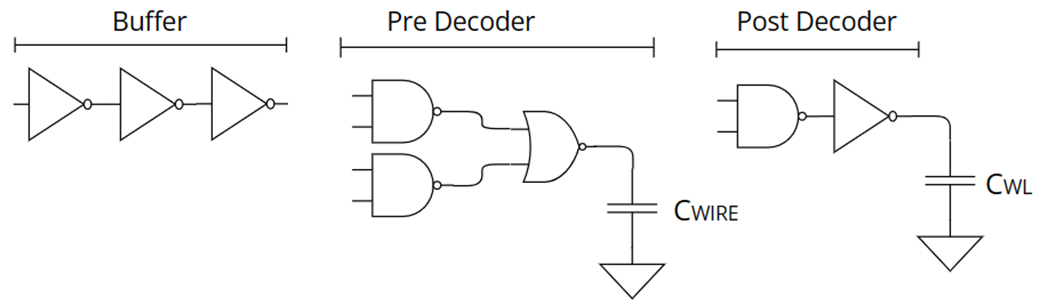

The total delay is

In [18]:
total_delay = rowdec_4x_final.delay + pre_post_metal.tau + post_WL_metal.tau
print(f"Total delay = {str(Quantity(total_delay, 's'))}")

Total delay = 173.96 ps
